In [1]:
#script written by Sebastian Heedt to analyze Coulomb blockade oscillations
%matplotlib inline
%load_ext autoreload

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import scipy, scipy.stats, scipy.integrate
from scipy import interpolate
import coulomb_oscillations_analysis as coa
import math
pi = math.pi

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

kB = 1.38064852e-23
e = 1.6021766208e-19
h = 6.626070040e-34

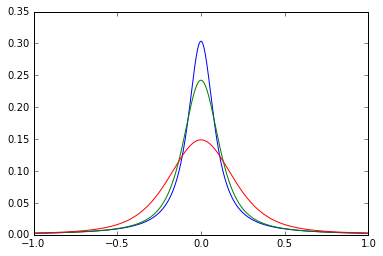

In [3]:
alpha = 0.072 #lever arm


def thermal_broadening(E, T):    
    return (1/(4.0*kB*T))*(np.cosh(E/(2.0*kB*T)))**(-2)


def Breit_Wigner(E, A, Vg, Vg_0, Gamma):
    'in units of 2e2/h'
    return 1/2/A/pi*h*Gamma/((h*Gamma/2)**2+(alpha*e*(Vg-Vg_0)-E)**2)


def CoulIntergrand(E, A, Vg, Vg_0, Gamma, T):
    'the intergrand for the Coulomb peak'
    return  thermal_broadening(E, T) * Breit_Wigner(E, A, Vg, Vg_0, Gamma) 


def G_CP(A, Vg, Vg_0, Gamma, T, offset):
    sampleE =  np.linspace(-10*kB*T-4*h*Gamma,10*kB*T+4*h*Gamma,10000)
    return scipy.integrate.simps(CoulIntergrand(sampleE, A, Vg, Vg_0, Gamma, T), x=sampleE) + offset


testVg = np.linspace(-0.001,0.001,500)
for t in [0.01,0.03,0.08]:
    testG = [G_CP(A=1e24, Vg=el, Vg_0=0, Gamma=3e9, T=t, offset=0) for el in testVg]
    plt.plot(testVg/1e-3,testG)


def ifitter(Vgate, Vg_0, A, Gamma, T, offset):
    #print(h*Gamma/e/1e-6, 4*kB*T/e/1e-6, Gamma/1e9, T)
    return [G_CP(A=A, Vg=el, Vg_0=Vg_0, Gamma=Gamma, T=T, offset=offset) for el in Vgate]

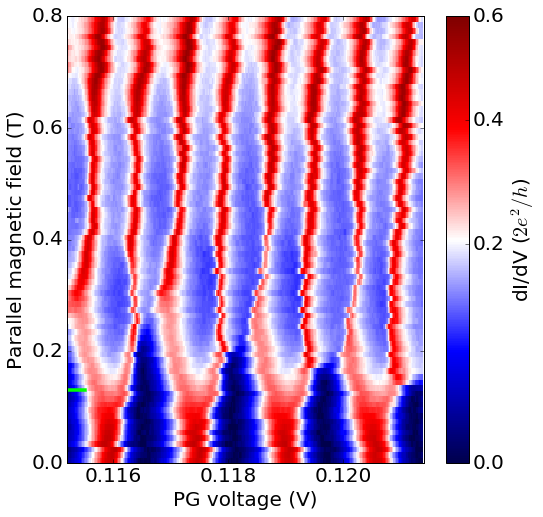

0.13


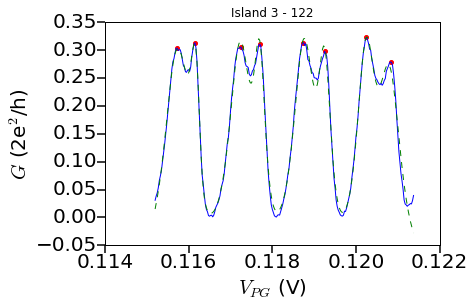

In [61]:
x_coord = np.loadtxt('H:\\My Documents\\Paper\\Coulomb peak analysis Island 3 - 110_x_coord.csv', delimiter=',')
y_coord = np.loadtxt('H:\\My Documents\\Paper\\Coulomb peak analysis Island 3 - 110_y_coord.csv', delimiter=',')
G_gate_shifted = np.loadtxt('H:\\My Documents\\Paper\\Coulomb peak analysis Island 3 - 110_G_shifted.csv', delimiter=',')
plt.figure(num=13, figsize=(8,8))
Vg_lim_left = 0.1152
Vg_lim_right = 0.1214
idx = x_coord.tolist().index(find_nearest(x_coord,Vg_lim_left))
idx2 = x_coord.tolist().index(find_nearest(x_coord,Vg_lim_right))
x_coord = x_coord[idx:idx2]
G = G_gate_shifted.transpose()[idx:idx2].transpose()
twoDmap = plt.pcolor(x_coord, y_coord, G, cmap=cm.get_cmap('seismic'), norm=cm.colors.PowerNorm(gamma=0.65, vmin=0, vmax=0.6))
cb_final=plt.colorbar(twoDmap, shrink=1, pad=0.05)
cb_final.set_label('dI/dV ($2e^2/h$)', size=20)
cb_final.set_ticks(np.arange(-0.2,0.8,0.2))
plt.xlim(Vg_lim_left, Vg_lim_right)
plt.ylim(0, 0.8)
plt.xlabel('PG voltage (V)', size=20)
plt.ylabel('Parallel magnetic field (T)', size=20)
plt.xticks(np.arange(0.116, 0.122, 0.002))
plt.yticks(np.arange(0, 1.0, 0.2))
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20)

linecut = 0.13 #Field in T where line cut is taken
plt.axhline(y=linecut, xmin=0, xmax=0.05, linewidth=3.5, color = 'lime')
plt.show()

index = y_coord.tolist().index(find_nearest(y_coord, linecut))
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(x_coord, G[index].tolist())
ax.set_title('Island 3 - 122')
ax.set_xlabel('$V_{PG}$ (V)', fontsize = 20)
ax.set_ylabel('$G$ (2e$^2$/h)', fontsize = 20)
#ax.set_xlim((Vg_start, Vg_end))
#ax.set_ylim((0, 0.4))
tick_spacing_x = 0.002
#tick_spacing_y = 5e-5
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.tick_params(direction='out', length=8, width=1.5, right='off', top='off')

peaks = coa.detect_peaks(G[index].tolist(), mph=0.25, mpd=10, threshold=0, edge='both', kpsh=False, valley=False, show=False, ax=None)
listpeaks = [x_coord[i] for i in peaks]
ax.scatter(listpeaks, [G[index].tolist()[x] for x in peaks], 16, marker='o', color='r')

Vgate=x_coord.tolist()
Vgates = [Vgate] * len(listpeaks)
Cond=G[index].tolist()
cond_peaks = [Cond[i] for i in peaks]

print(linecut)
fit_single_trace = True
if fit_single_trace == True:
    A = 2.0e24
    Gamma = 3.0e9
    T = 0.030
    offset = 0.07
    guess = []
    guess += listpeaks
    guess += (np.array([A] * len(listpeaks))*max(cond_peaks)/np.array(cond_peaks)).tolist()
    guess += [Gamma] * len(listpeaks)
    guess += [T, offset]
    
    def nifitter(Vgates, *params):
        r = [0] * len(Vgates[0])
        for i,gate in enumerate(Vgates):
            r = np.array(r)+np.array(ifitter(gate, params[i], params[i+len(Vgates)], params[i+2*len(Vgates)], params[-2], params[-1]))
        r = r - (len(Vgates)-1)*params[-1]
        return r.tolist() #np.array(r).flatten()
    
    popt_list = []
    pcov_list = []
    popt = np.array(guess)
    
    popt, pcov = scipy.optimize.curve_fit(nifitter, Vgates, Cond, p0=guess, xtol = 0.0000004, maxfev = 1200)
    popt_list.append(popt)
    pcov_list.append(pcov)
    
    plt.plot(Vgates[0], nifitter(Vgates, *popt), 'g--')
    plt.show()

    
fit_peaks = False
if fit_peaks == True:
    #Fit all Coulomb peaks using the same electron temperature:
    A = 2.0e24
    Gamma = 3.0e9
    T = 0.030
    offset = 0.07
    guess = []
    guess += listpeaks
    guess += (np.array([A] * len(listpeaks))*max(cond_peaks)/np.array(cond_peaks)).tolist()
    guess += [Gamma] * len(listpeaks)
    guess += [T, offset]
    
    def nifitter(Vgates, *params):
        r = [0] * len(Vgates[0])
        for i,gate in enumerate(Vgates):
            r = np.array(r)+np.array(ifitter(gate, params[i], params[i+len(Vgates)], params[i+2*len(Vgates)], params[-2], params[-1]))
        r = r - (len(Vgates)-1)*params[-1]
        return r.tolist() #np.array(r).flatten()
    
    popt_list = []
    pcov_list = []
    popt = np.array(guess)
    field_values = np.linspace(0.00, 0.08, 9)
    for linecut in field_values:
        print(linecut)
        index = y_coord.tolist().index(find_nearest(y_coord, linecut))
        plt.plot(x_coord, G[index].tolist())
        peaks = coa.detect_peaks(G[index].tolist(), mph=0.20, mpd=15, threshold=0, edge='both', kpsh=False, valley=False, show=False, ax=None)
        listpeaks = [x_coord[i] for i in peaks]
        plt.scatter(listpeaks, [G[index].tolist()[x] for x in peaks], 16, marker='o', color='r')
        Cond=G[index].tolist()
        cond_peaks = [Cond[i] for i in peaks]
        
        guess = []
        guess += listpeaks
        #guess += (np.array([A] * len(listpeaks))*max(cond_peaks)/np.array(cond_peaks)).tolist()
        #guess += [Gamma] * len(listpeaks)
        #guess += [T, offset]
        guess += popt.tolist()[len(listpeaks):]
        
        popt, pcov = scipy.optimize.curve_fit(nifitter, Vgates, Cond, p0=guess, xtol = 0.000001, maxfev = 1200)
        popt_list.append(popt)
        pcov_list.append(pcov)

    
        #h*Gamma, 4kT, Gamma/GHz, T

        plt.plot(Vgates[0], nifitter(Vgates, *popt), 'g--')
        plt.show()
        plt.figure()

In [62]:
print(popt_list)
print(pcov_list)

[array([  1.15715753e-01,   1.16115945e-01,   1.17231407e-01,
         1.17701633e-01,   1.18755086e-01,   1.19253515e-01,
         1.20235011e-01,   1.20803450e-01,   2.13539013e+23,
         1.17060178e+24,   2.40644922e+23,   8.48470077e+23,
         2.52327965e+23,   7.00104706e+23,   3.53198206e+23,
         2.88148389e+23,   9.90812311e+09,   1.55829342e+06,
         8.55209993e+09,   1.11460010e+09,   7.96454747e+09,
         2.04559598e+09,   5.81387071e+09,   8.40263922e+09,
         6.17430211e-02,  -1.12892527e-01])]
[array([[  5.19670928e-11,  -2.42984640e-14,  -6.21896713e-12,
         -2.20946172e-12,  -8.56338651e-13,   3.01195678e-12,
         -3.45412197e-12,   3.07054081e-12,  -5.34595440e+16,
          4.86742477e+17,   1.11124969e+16,  -1.35229272e+17,
         -2.01597239e+16,  -1.78352378e+16,  -1.54172325e+16,
         -2.53705095e+16,   2.51493247e+03,  -3.38042547e-01,
         -6.64445721e+02,   5.52985510e+02,   5.64956296e+02,
          1.33627783e+02,   2.9

In [63]:
x_coord = np.loadtxt('H:\\My Documents\\Paper\\Coulomb peak analysis Island 3 - 110_x_coord.csv', delimiter=',')
Vg_lim_left = 0.1152
Vg_lim_right = 0.1214
idx = x_coord.tolist().index(find_nearest(x_coord,Vg_lim_left))
idx2 = x_coord.tolist().index(find_nearest(x_coord,Vg_lim_right))
x_coord = x_coord[idx:idx2]
Vgate=x_coord.tolist()
Vgates = [Vgate] * 8
fit_array = np.array([  1.15715753e-01,   1.16115945e-01,   1.17231407e-01,
         1.17701633e-01,   1.18755086e-01,   1.19253515e-01,
         1.20235011e-01,   1.20803450e-01,   2.13539013e+23,
         1.17060178e+24,   2.40644922e+23,   8.48470077e+23,
         2.52327965e+23,   7.00104706e+23,   3.53198206e+23,
         2.88148389e+23,   9.90812311e+09,   1.55829342e+06,
         8.55209993e+09,   1.11460010e+09,   7.96454747e+09,
         2.04559598e+09,   5.81387071e+09,   8.40263922e+09,
         6.17430211e-02,  -1.12892527e-01])
G2 = nifitter(Vgates, *fit_array)
peaks = coa.detect_peaks(G2, mph=0.25, mpd=10, threshold=0, edge='both', kpsh=False, valley=False, show=False, ax=None)
print([G2[x] for x in peaks])

[0.3026137439088997, 0.3123666650222345, 0.31568744321935127, 0.3203710591922636, 0.3208641139476374, 0.30753633457412766, 0.32328262391259527, 0.2743600892349498]
